In [2]:
import numpy as np
import matplotlib.pyplot as plt

# generates a random quntum state for n spins 1/2 as
# a rank n tensor of probability amplitudes psi_{0,1,2,\dots,n-1}
def random(n):
  x = np.random.rand(2**n)+1.j*np.random.rand(2**n)
  x = x/np.sqrt(np.vdot(x,x))
  x = np.reshape(x,list(np.repeat(2,n)))
  return x

# generates a random ground state of a classical 1D Ising model with n spins 1/2 as
# a rank n tensor of probability amplitudes psi_{0,1,2,\dots,n-1}
def Is_GS(n):
  x = np.random.rand(2)+1.j*np.random.rand(2)
  x = x/np.sqrt(np.vdot(x,x))
  v = np.zeros(2**n,dtype=np.complex128)
  v[0] = x[0]
  v[2**n-1] = x[1]
  v = np.reshape(v,list(np.repeat(2,n)))
  return v

#generates an expectation value O of an operator o acting at a site s 
#O=psi_{i0,...,i_{s-1},j,i_{s+1},...,i_n}^* o_{j,k} psi_{i0,...,i_{s-1},k,i_{s+1},...,i_n} (Einstein's convention implied) 
def EV_1s(psi,s,op):
   n = len(psi.shape)
   psiop = np.tensordot(op,psi,axes=((1,),(s,)))
   psiop = np.transpose(np.reshape(psiop,(2,2**(s),2**(n-s-1))),(1,0,2))
   EV = np.vdot(np.reshape(psi,-1),np.reshape(psiop,-1))
   return np.real(EV)

#generates an expectation value O of an operator o acting at sites s,s+1 
#O=psi_{i0,...,i_{s-1},j,k,i_{s+2},...,i_n}^* o_{j,k,l,m} psi_{i0,...,i_{s-1},l,m,i_{s+2},...,i_n} (Einstein's convention implied)
def EV_2s(psi,s,op):
   n = len(psi.shape)
   psiop = np.tensordot(op,psi,axes=((2,3),(s,s+1)))
   psiop = np.transpose(np.reshape(psiop,(4,2**(s),2**(n-s-2))),(1,0,2))
   EV = np.vdot(np.reshape(psi,-1),np.reshape(psiop,-1))
   return np.real(EV)
 


In [3]:
import numpy as np

def to_left_canonical_mps(state):
    dim = len(state.shape)
    bond_dim = 1

    mps = []

    #reshape the state tensor to get 2x2 U matrix from SVD and perform first SVD
    state = np.reshape(state, (2,-1))
    U,S,V = np.linalg.svd(state, full_matrices=False)

    #U is 2x2 matrix, ready to use as first part of MPS, S is absorbed into V and will be further factorized
    mps.append(U)
    V = np.diag(S)@V

    # loop for rank 3 product tensors with number of left bonds smaller than right bonds
    for i in range(int((dim-1)/2)):
        bond_dim += 1

        V = np.reshape(V, (2**bond_dim,-1))
        U,S,V = np.linalg.svd(V, full_matrices=False)
        U = np.reshape(U, (2**(bond_dim-1),2,-1))  

        mps.append(U)
        V = np.diag(S)@V

    #cases of even dimension need to have more bonds at the beginning of the 2nd loop
    if(dim%2 == 0): bond_dim += 1

    #loop for the remaining rank 3 tensors
    for i in range(int(dim/2 - 1)):
        V = np.reshape(V, (2**(bond_dim),-1))
        U,S,V = np.linalg.svd(V, full_matrices=False)
        U = np.reshape(U, (2**(bond_dim-1),2,-1))

        mps.append(U)
        V = np.diag(S)@V

        bond_dim -= 1
    
    mps.append(V)
    return(mps)

def get_state(MPS):
    #contracting neighbouring indices of every tensor being a part of MPS
    state = np.tensordot(MPS[0], MPS[1], axes = [1,0])

    for i in range(2, len(MPS)):
        state = np.tensordot(state, MPS[i], axes = [-1,0])

    return state

def check_state(MPS,state):
    eps = 1e-15
    is_close = np.allclose(abs(get_state(MPS)), abs(state), atol = eps)
    return is_close

def bond_dim_check(mps):
    bond_dim = 2
    if (len(mps) < 2): 
        print("too small dimension of MPS!")
        return 0
    for i in range(len(mps)):
        a = mps[i].shape
        for j in range(len(a)):
            if (bond_dim < a[j]):
                bond_dim = a[j]
    return bond_dim


In [4]:
dim = 12
eps = 1e-15
Z = np.diag([1,-1])

state = random(dim)


MPS = to_left_canonical_mps(state)
for i in range(len(MPS)):
    print(MPS[i].shape)

(2, 2)
(2, 2, 4)
(4, 2, 8)
(8, 2, 16)
(16, 2, 32)
(32, 2, 64)
(64, 2, 32)
(32, 2, 16)
(16, 2, 8)
(8, 2, 4)
(4, 2, 2)
(2, 2)


In [5]:
# check whether MPS correctly reproduces state
check_state(MPS,state)

True

In [6]:
def is_left_canonical(MPS):
    eps = 1e-14
    unitary_counter = 0
    dim = len(MPS)

    #leftmost contracted matrix should be of shape 2x2 and should be unitary
    if(np.allclose(MPS[0]@MPS[0].T.conj(), np.diag([1,1]), atol = eps)): unitary_counter += 1

    #double contracted tensors in the middle of MPS should also give unitary matrices
    for i in range(1,len(MPS)-1):
        m = MPS[i]
        mt = m.T.conj()
        mmt = np.einsum('ijk,lji->kl', m, mt)
        bonds = mmt.shape[0]
        if(np.allclose(mmt, np.diag(np.ones(bonds)), atol = eps)): unitary_counter += 1


    if(unitary_counter == dim - 1): 
        return True
    else:
        return False



In [7]:
#check whether MPS is indeed left canonical
is_left_canonical(MPS)

True

In [8]:
def left_canonical_mps_norm(MPS):
    #contraction of leftmost MPS matrices
    norm = np.einsum('ij,ki->jk',MPS[0], MPS[0].T.conj())
    
    #loop for contracting first the conjugate element of MPS followed by contraction of original one 
    for i in range(1,len(MPS)-1):
        norm = np.tensordot(norm, MPS[i].T.conj(), axes=[1,2])
        norm = np.einsum('ijk, ikl->lj',norm,MPS[i])
        print(norm.shape)

    #final contraction of two remaining matrices
    norm = np.tensordot(norm, MPS[-1].T.conj(), axes=[1,1])
    norm = np.einsum('ij, ij',norm,MPS[-1])
    return np.real(norm)

def state_exp_value(MPS):
    #contraction of leftmost MPS matrices
    norm = np.einsum('ij,ki->jk',MPS[0], MPS[0].T.conj())

    #loop for contracting first the conjugate element of MPS followed by contraction of original one
    for i in range(1,len(MPS)-1):
        norm = np.tensordot(norm, MPS[i].T.conj(), axes=[1,2])
        norm = np.einsum('ijk, ikl->lj',norm,MPS[i])

    #contracting Z operator with rightmost matrices
    Z_contr = np.tensordot(MPS[-1], Z, axes=[1,0])
    Z_contr = np.tensordot(Z_contr, MPS[-1].T.conj(), axes=[1,0])
    
    #final double contraction loop result with result of operator Zcontraction 
    norm = np.einsum('ij, ij',norm,Z_contr)
    return np.real(norm)

In [9]:
#check whether expected values are the same for both methods
print(state_exp_value(MPS))
print(EV_1s(state,dim-1,Z))

0.00490112571959537
0.0049011257195930025


In [10]:
def trunc_left_canonical_mps(state, isTruncated:bool):
    eps = 1e-15
    dim = len(state.shape)
    bond_dim = 1

    mps = []

    #reshape the state tensor to get 2x2 U matrix from SVD and perform first SVD
    state = np.reshape(state, (2,-1))
    U,S,V = np.linalg.svd(state, full_matrices=False)

    #U is 2x2 matrix, ready to use as first part of MPS, S is absorbed into V and will be further factorized
    mps.append(U)
    V = np.diag(S)@V

    # loop for rank 3 product tensors with number of left bonds smaller than right bonds
    for i in range(dim-2):
        bond_dim = U.shape[-1]

        V = np.reshape(V, (2*bond_dim,-1))
        U,S,V = np.linalg.svd(V, full_matrices=False)

        #truncation (discarding singular values and corresponding collumn vectors from U and row vectors from V) if singular value is smaller than eps = 1e-15
        if(isTruncated == True):
            j = 0
            while(j < len(S)):
                if (abs(S[j]) < eps):
                    U = np.delete(U, j, 1)
                    S = np.delete(S, j)
                    V = np.delete(V, j, 0)
                else:
                    j += 1
    
        U = np.reshape(U, (bond_dim,2,-1))
        mps.append(U)
        V = np.diag(S)@V



    
    mps.append(V)
    return(mps)

In [11]:
#truncating mps and check whether is correctly encodes initial state and is left canonical
trunc_MPS = trunc_left_canonical_mps(state,isTruncated = True)

print(check_state(trunc_MPS,state))

print(is_left_canonical(trunc_MPS))



True
True


In [12]:
#truncated shape
for i in range(len(trunc_MPS)):
    print(trunc_MPS[i].shape)

(2, 2)
(2, 2, 4)
(4, 2, 8)
(8, 2, 16)
(16, 2, 32)
(32, 2, 64)
(64, 2, 32)
(32, 2, 16)
(16, 2, 8)
(8, 2, 4)
(4, 2, 2)
(2, 2)


In [13]:
#creating MPS of Ising groud state and truncating it
ising_state = Is_GS(dim)
trunc_ising_state = trunc_left_canonical_mps(ising_state, isTruncated=True)

#shape of truncated Ising MPS
for i in range(len(trunc_ising_state)):
    print(trunc_ising_state[i].shape)

#check whether truncated MPS of Ising groud state is correctly recovered
print("\nTruncated MPS still encodes ground state: ", end=" ")
print(check_state(trunc_ising_state, ising_state))

(2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2)

Truncated MPS still encodes ground state:  True


In [14]:
def to_mixed_canonical_mps(mps, site):
    dim = len(mps)
    MPS = mps

    for i in reversed(range(site+1,dim)):

        right_bond_shape= mps[i].shape
        left_bond_shape = mps[i-1].shape

        V = np.reshape(MPS[i], (left_bond_shape[-1], -1))
        U,S,V = np.linalg.svd(V, full_matrices=False )

        MPS[i] = np.reshape(V, right_bond_shape)
        U = MPS[i-1] @ U @ np.diag(S)
        MPS[i-1] = np.reshape(U, left_bond_shape)

    return MPS


In [15]:
for i in range(len(to_mixed_canonical_mps(MPS,5))):
    print(to_mixed_canonical_mps(MPS,5)[i].shape)

(2, 2)
(2, 2, 4)
(4, 2, 8)
(8, 2, 16)
(16, 2, 32)
(32, 2, 64)
(64, 2, 32)
(32, 2, 16)
(16, 2, 8)
(8, 2, 4)
(4, 2, 2)
(2, 2)


In [16]:
def is_mixed_canonical(MPS, site):
    eps = 1e-14
    identity_counter = 0
    dim = len(MPS)
    

    #leftmost contracted matrix should be of shape 2x2 and should be unitary
    if(np.allclose(MPS[0]@MPS[0].T.conj(), np.diag([1,1]), atol = eps)): identity_counter += 1

    #double contracted tensors in the middle of MPS should contract to identity matrices
    for i in range(1,site):
        m = MPS[i]
        mt = m.T.conj()
        mmt = np.einsum('ijk,lji->kl', m, mt)
        bonds = mmt.shape[0]
        if(np.allclose(mmt, np.diag(np.ones(bonds)), atol = eps)): identity_counter += 1
        
    for i in range(site+1, dim-1):
        m = MPS[i]
        mt = m.T.conj()
        mmt = np.einsum('ijk,lji->kl', mt, m)
        bonds = mmt.shape[0]
        if(np.allclose(mmt, np.diag(np.ones(bonds)), atol = eps)): identity_counter += 1
  
    #check for rightmost matrix
    if(np.allclose(MPS[-1]@MPS[-1].T.conj(), np.diag([1,1]), atol = eps)): identity_counter += 1

    if(identity_counter == dim - 1): 
        return True
    else:
        return False


def mixed_canonical_mps_norm(mps, site):
    if(is_mixed_canonical(mps,site) == False ): return "not mixed canonical"

    #for mixed canonical norm we need to contract only orthogonality center
    m = mixed_mps[site]
    mt = m.T.conj()
    mmt = np.einsum('ijk,kji', mt, m)

    return np.real(mmt)


In [17]:
#converting left-canonical MPS to mixed-canonical one and checking whether it is indeed canonical
site = 4

mixed_mps = to_mixed_canonical_mps(MPS, site)
print("\nIs mixed canonical:", is_mixed_canonical(mixed_mps, site), end = "")

#checking norm of mixed canonical mps
print("\nMixed canonical norm:", mixed_canonical_mps_norm(mixed_mps, site), end="")


Is mixed canonical: True
Mixed canonical norm: 0.9999999999999928

In [18]:
def one_site_exp_value(state, site, operator):
    #transforming state to mixed canonical mps with orthogonality center at site 'site'
    mps = trunc_left_canonical_mps(state, isTruncated=True)
    mps = to_mixed_canonical_mps(mps, site)
    
    m = mps[site]
    mt = m.T.conj()

#left and right matrices have only 2 indices whereas tensors in between have 3, hence 3 cases
    exp_val = 0
    if(site == 0): 
        m = np.einsum('ij,ik->jk', m, operator)
        exp_val = np.einsum('ij,ij', m, mt)
    elif(site == len(mps)-1):
        m = np.einsum('ij,jk->ik', m, operator)
        exp_val = np.einsum('ij,ji', m, mt)
    else:
        m = np.einsum('ijk,jl->ilk', m, operator)
        exp_val = np.einsum('ijk,kji', m, mt)


    return np.real(exp_val)


def two_site_exp_value(state, site, operator):
    if(site == len(state.shape) - 1): return "Error: site too large"
    #transforming state to mixed canonical mps with orthogonality center at site 'site'
    mps = trunc_left_canonical_mps(state, isTruncated=True)
    mps = to_mixed_canonical_mps(mps, site)
    
    m = mps[site]
    mt = m.T.conj()
    m_next = mps[site+1]
    mt_next = m_next.T.conj()
    
    #left and right matrices have only 2 indices whereas tensors in between have 3, hence 3 cases
    exp_val = 0

    if(len(state.shape) == 2):
        m = np.einsum('ik,kj,jl->li', mt, operator, m)
        m_next = np.einsum('ik,kj,jl->li', mt_next, operator, m_next)

        exp_val = np.einsum('ij,ij', m, m_next)

    elif(site == 0): 
        m = np.einsum('ik,kj,jl->li', mt, operator, m)
        m_next = np.einsum('ijk,jq,pqr->prki', mt_next, operator, m_next)

        exp_val = np.einsum('ij,iljl', m, m_next)

    elif(site == len(mps)-2):
        m = np.einsum('ijk,jq,pqr->prki', mt, operator, m)
        m_next = np.einsum('ik,kj,jl->li', mt_next, operator, m_next)

        exp_val = np.einsum('ijil,jl', m, m_next)

    else:
        m = np.einsum('ijk,jq,pqr->prki', mt, operator, m)
        m_next = np.einsum('ijk,jq,pqr->prki', mt_next, operator, m_next)

        exp_val = np.einsum('ijik,jlkl', m, m_next)

    return np.real(exp_val)



In [19]:
exp_site_one = 3

print("\nCalculated one site expectation value at site %d: " % exp_site_one, one_site_exp_value(state, exp_site_one, Z))
print("\nReference one site expectation value at site %d: " % exp_site_one, EV_1s(state, exp_site_one, Z))


exp_site_two = 3

print("\nCalculated two site expectation value at site %d: " % exp_site_two, two_site_exp_value(state, exp_site_two, Z))
# print("\nReference one site expectation value at site %d: " % exp_site_two, EV_2s(state, exp_site_two, np.array([Z,Z])))
print("\nReference two site expectation value does not work.")


Calculated one site expectation value at site 3:  0.0008313826800103305

Reference one site expectation value at site 3:  0.0008313826800103504

Calculated two site expectation value at site 3:  0.007253890363264957

Reference two site expectation value does not work.


<function matplotlib.pyplot.show(close=None, block=None)>

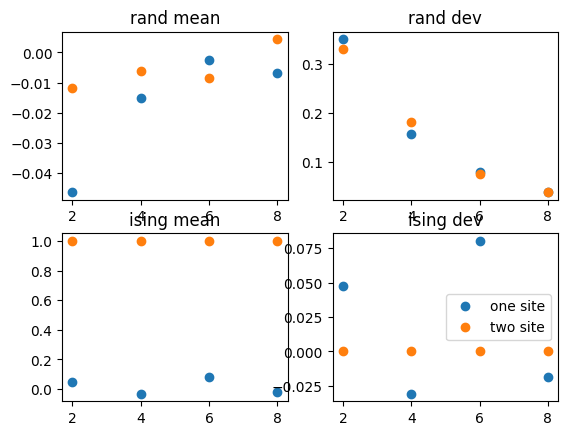

In [20]:
# mean and standard deviation of expectation value of Z
max_range = 10
max_iter = 100

num_cases = int((max_range-2)/2)

exp_one_rand = np.zeros((num_cases, 100))
exp_one_ising = np.zeros((num_cases, 100))
exp_two_rand = np.zeros((num_cases, 100))
exp_two_ising = np.zeros((num_cases, 100))

for n in range(num_cases):
    dim = 2*n + 2
    # site = int((dim-1)/2)
    site = 0
    for i in range(max_iter):
        state_rand = random(dim)
        state_ising = Is_GS(dim)
        # print(dim, len(state.shape))
        exp_one_rand[n,i] = one_site_exp_value(state_rand, site, Z)
        exp_one_ising[n,i] = one_site_exp_value(state_ising, site, Z)
        
        exp_two_rand[n,i] = two_site_exp_value(state_rand, site, Z)
        exp_two_ising[n,i] = two_site_exp_value(state_ising, site, Z)
        

mean_exp_one_rand = np.mean(exp_one_rand, axis=1)
mean_exp_one_ising = np.mean(exp_one_ising, axis=1)

mean_exp_two_rand = np.mean(exp_two_rand, axis=1)
mean_exp_two_ising = np.mean(exp_two_ising, axis=1)

dev_exp_one_rand = np.std(exp_one_rand, axis=1)
dev_exp_one_ising = np.std(exp_one_ising, axis=1)

dev_exp_two_rand = np.std(exp_two_rand, axis=1)
dev_exp_two_ising = np.std(exp_two_ising, axis=1)

     

x = range(2, max_range, 2)

plt.subplot(2,2,1)
plt.plot(x, mean_exp_one_rand, 'o', label = "one site")
plt.title("rand mean")

plt.subplot(2,2,2)
plt.plot(x, dev_exp_one_rand, 'o', label = "one site")
plt.title("rand dev")

plt.subplot(2,2,3)
plt.plot(x, mean_exp_one_ising, 'o', label = "one site")
plt.title("ising mean")

plt.subplot(2,2,4)
plt.plot(x, mean_exp_one_ising, 'o', label = "one site")
plt.title("ising dev")



plt.subplot(2,2,1)
plt.plot(x, mean_exp_two_rand, 'o', label = "two site")
plt.title("rand mean")

plt.subplot(2,2,2)
plt.plot(x, dev_exp_two_rand, 'o', label = "two site")
plt.title("rand dev")

plt.subplot(2,2,3)
plt.plot(x, mean_exp_two_ising, 'o', label = "two site")
plt.title("ising mean")

plt.subplot(2,2,4)
plt.plot(x, dev_exp_two_ising, 'o', label = "two site")
plt.title("ising dev")

plt.legend(loc="right")
plt.show


In [21]:
EV_2s(Is_GS(8),0 ,np.array([[[-1,0],[0,1]],[[-1,0],[0,1]]]))

IndexError: tuple index out of range

In [ ]:
isingcheck = Is_GS(4)

trunc_ising_check= trunc_left_canonical_mps(isingcheck, isTruncated=True)

# for i in range(len(trunc_ising_check)):
#     print(trunc_ising_check[i].shape)


n = 2

print(trunc_ising_check)
print(is_mixed_canonical(trunc_ising_check,n))
mix = to_mixed_canonical_mps(trunc_ising_check,n)
print(trunc_ising_check)
print(is_mixed_canonical(trunc_ising_check, n))
print(is_mixed_canonical(mix,n))

# print(trunc_ising_check)

trunc_ising_mixed_mps = to_mixed_canonical_mps(trunc_ising_check,n)

print(trunc_ising_check)
is_mixed_canonical(trunc_ising_check,n)
# print(trunc_ising_mixed_mps)



[array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]]), array([[[-0.7933629 -0.60874898j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ]],

       [[ 0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        , -0.79334051-0.60877816j]]]), array([[[1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]],

       [[0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]]), array([[-0.89932805+0.j,  0.        +0.j],
       [ 0.        +0.j, -0.43727457+0.j]])]
False
[array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]]), array([[[-0.7933629 -0.60874898j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ]],

       [[ 0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        , -0.79334051-0.60877816j]]]), array([[[0.89932805+0.j, 0.        +0.j],
        [0.        +0.j, 0.        +0.j]],

       [[0.        +0.j, 0.        +0.j],
        [0.        +0.j, 0.43727457+0.j]]]), array([[-1.+0.j, -0.+0.j],
 

True

In [ ]:
trunc_ising_check[-1]@trunc_ising_check[-1].T.conj()

n = 2
np.einsum('ijk,lji->kl', trunc_ising_check[n], trunc_ising_check[n].T.conj())
is_mixed_canonical(trunc_ising_check,0)



True

In [ ]:
def hamiltonian_mps(state):
    h = 1
    hz = 1

    hZ = np.diag([hz, -hz])
    minus_hZ = np.diag([-hz,hz])
    minus_hX = np.array([[0,-h],[-h,0]])

    H_0 = np.zeros((2,2,3))
    H_0[:,:,0] = minus_hX + minus_hZ
    H_0[:,:,1] = minus_hZ
    H_0[:,:,2] = np.identity(2)

    H_j = np.zeros((2,2,3,3))
    H_j[:,:,0,0] = np.identity(2)
    H_j[:,:,0,1] = np.zeros((2,2))
    H_j[:,:,0,2] = np.zeros((2,2))
    H_j[:,:,1,0] = hZ
    H_j[:,:,1,1] = np.zeros((2,2))
    H_j[:,:,1,2] = np.zeros((2,2))
    H_j[:,:,2,0] = minus_hX + minus_hZ
    H_j[:,:,2,1] = minus_hZ
    H_j[:,:,2,2] = np.zeros((2,2))

    print(hZ)
    print(minus_hZ)
    print(minus_hX)

    print(H_j)
    

    


In [ ]:
hamiltonian_mps(state)

[[ 1  0]
 [ 0 -1]]
[[-1  0]
 [ 0  1]]
[[ 0 -1]
 [-1  0]]
[[[[ 1.  0.  0.]
   [ 1.  0.  0.]
   [-1. -1.  0.]]

  [[ 0.  0.  0.]
   [ 0.  0.  0.]
   [-1.  0.  0.]]]


 [[[ 0.  0.  0.]
   [ 0.  0.  0.]
   [-1.  0.  0.]]

  [[ 1.  0.  0.]
   [-1.  0.  0.]
   [ 1.  1.  0.]]]]
